#Importing some required libraries
in this stage we would imprort some libraries that would be needed for our work, also we would fix the random seed to make the results reproducable

In [1]:
import numpy as np
import copy
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras import regularizers
from keras.layers import Dropout
from sklearn.preprocessing import StandardScaler
from abc import ABC, abstractmethod
from random import random,getrandbits,choices
import seaborn as sns
from scipy import stats
from scipy.special import softmax
import matplotlib.pyplot as plt
import os
import time
import tkinter as tk
from tkinter import messagebox
#initialize for random seeds/states
tf.keras.backend.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
rng = np.random.default_rng(12345)
np.random.seed(42)
tf.random.set_seed(42)

#Building game environment
In this stage we would build the game class for our environment. this part of the code consists of trainin function, transition function, reward function, as important parts of the q-learning. Also there are some other functions like play_gui, to make an environment interactable with a human user.

In [2]:
class paper_game(ABC):
    def __init__(self, start_state):
        self.state=start_state
    
    @abstractmethod
    def transition(state, action, player):
        #return next state
        pass
    
    @abstractmethod
    def reward(self, state, action, player):
        #return reward immediately after action
        pass
    
    @abstractmethod
    def policy(self, state):
        #return action
        pass
    
    @abstractmethod
    def Q_func(self, state, action):
        pass
    
    @abstractmethod
    def Q_update(self, state, action, reward_1, maxQ, player):
        pass

In [3]:
class tic_tac_toe(paper_game):
#state: 3x3 array to represent board config, with 1 representing self-checker, -1 representing opponent-checker, 0 representing empty
    def __init__(self, start_state=np.zeros((3,3), dtype=np.int8), epsilon=0.9, alpha=0.5, gamma=0.5):
        self.state=start_state
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.Q = np.zeros((19683, 9))  #initialize Q matrix with state 'reference' (see ref function) and action key (see key function)    
    
    def transition(self, state, action, player):
        #action: a list of row and column index to indicate which cell is chosen
        #player: 1 or -1
        #applicable to both tic_tac_toe and Connect-4
        #return next state
        new_state = copy.deepcopy(state)
        new_state[action[0]][action[1]] = player
        return new_state
    
    def win_status(self, s):
        #s: state, 
        #return: whether win or not
        win = 3 in np.sum(s, axis=0) or 3 in np.sum(s, axis=1) or np.sum(s.diagonal())==3 or np.sum(np.fliplr(s).diagonal())==3
        return win

    def lose_status(self, s):
        #s: state, 
        #return: whether win or not
        lose = -3 in np.sum(s, axis=0) or -3 in np.sum(s, axis=1) or np.sum(s.diagonal())==-3 or np.sum(np.fliplr(s).diagonal())==-3
        return lose
    
    def ref(self, state):
        #change state matrix into vector
        ref = np.sum(np.matrix([1,3,3**2,3**3,3**4,3**5,3**6,3**7,3**8]) @ np.reshape((state + 1).flatten(),(9,1)))
        return ref
    
    def key(self, action):
        #change actions [r, c] into numbers 0-8
        return 3*action[0]+action[1]
    
    def action_list(self, state):
        act_list = np.where(state==0)
        return act_list

    def reward(self, state, action, player):
        s = player * self.transition(state, action, player)
        if self.win_status(s):
            reward = 100
        elif self.lose_status(s):
            reward = -50
        else:
            reward = 0
        return reward
    
    def Q_func(self, state, action):
        Q = self.Q[self.ref(state)][self.key(action)]
        return Q

    def Q_update(self, state, action, reward_1, maxQ, player):
        #state of board instead of current player's perspective
        #reward_1: reward of player 1 regardless of who is current player
        #maxQ: player's maxQ after another action
        #player: 1 or -1
        s = player*state
        self.Q[self.ref(s)][self.key(action)] += self.alpha*(reward_1*player + self.gamma*maxQ - self.Q[self.ref(s)][self.key(action)] )


    def random_move(self, state):
        #a random move based on available action would be outputed in this function
        act_list = self.action_list(state)
        i = np.random.randint(len(act_list[0]))
        action = [act_list[0][i],act_list[1][i]]
        return action

    def best_move(self, state):
        #in this function the agent would look for the best action according to
        #the q values in the Q-Matrix
        act_list = self.action_list(state)
        maxQ = -10000
        for i in range (len(act_list[0])):
            a = [act_list[0][i],act_list[1][i]]
            temp = self.Q_func(state, a)
            if temp > maxQ:
                maxQ = temp
                action = a
        return action, maxQ
    
    def boltzmann_softmax(self, state):
        #based on the q-values of the available actions, we would give them a probability
        # so the agent won't take the worst actions and tend to choose better resulting ones
        act_list = self.action_list(state)
        actions = []
        Q_values = []
        for i in range (len(act_list[0])):
            a = [act_list[0][i],act_list[1][i]]
            actions.append(a)
            Q_values.append(self.Q_func(state, a))
        
        return actions, Q_values
        
    
    def policy(self, state):
        #the policy of the game would be selected in this stage. the decay factor has been
        #hard-coded in epsilon greedy policy.
        if self.selected_policy == 'epsilon greedy':
            exploit = (not self.train) or rng.random()> self.epsilon or self.play
            if exploit:
                action, maxQ = self.best_move(state)
            else:
                action = self.random_move(state)
            if self.epsilon < 0.5:
                self.epsilon *= 0.9999
            else:
                self.epsilon *= 0.99999    
            return action
    
        elif self.selected_policy == 'random':
            action = self.random_move(state)
            return action
        
        elif self.selected_policy == 'improved epsilon greedy':
            exploit = (not self.train) or rng.random()> self.new_epsilon or self.play
            if exploit:
                action, maxQ = self.best_move(state)
            else:
                action = self.random_move(state)
            if self.new_epsilon < 0.5:
                self.new_epsilon *= 0.9999
            else:
                self.new_epsilon *= 0.99999    
            return action
        
        elif self.selected_policy == 'boltzmann':
            
            T = self.epochs - self.epoch_number + 1
            
            act_list = self.action_list(state)
            actions = []
            Q_values = []
            probabilities = []
            for i in range (len(act_list[0])):
                a = [act_list[0][i],act_list[1][i]]
                actions.append(a)
                Q_values.append(self.Q_func(state, a))
            
            Q_values = list(map(lambda x: (np.e ** x)/T, Q_values ))
            
            for Q in Q_values:
                probabilities.append(Q / sum(Q_values))
                
            action = choices(actions, weights = probabilities)[0]

            return action
            
            
    def train(self, train_number=2000, evaluation = False, opponent = 'random', selected_policy = 'epsilon greedy',verbose = 'True'):
        #starting the training phase and updating the Q-Matrix
        self.selected_policy = selected_policy
        self.win_count_list = []
        self.epochs = train_number
        self.train = True
        self.play = False
        #loop by train_number
        start_time = time.time()
        for i in range (1,train_number+1):
            self.new_epsilon = 1 - 1/(7*i)
            self.epoch_number = i
            if verbose == True and i % 10000 == 0 and i != 0:
                end_time = time.time()
                elp_time = '{:.2f}'.format(end_time - start_time)
                print(f'Training Phase, epoch {i}, elapsed time:{elp_time}')
                start_time = time.time()
                
            states =[]
            state = self.state #start state
            states.append(state)
            actions=[]
            r1=[0] #reward list at different times for player 1; for player -1: use zero sum property
            t = 0
            #choose who is X, i.e. plays first
            player = 1 #as this is self-play, we simply assume 1 always plays first and be playerX
            endgame = False
            while not endgame:
                #update his Q before action if previous has action
                s = player * state
                if t >=2:
                    action, maxQ = self.best_move(s)
                    self.Q_update(states[t-2], actions[t-2], r1[t], maxQ, player)
                    
                #action
                action = self.policy(s)
                actions.append(action)
                t += 1
                r1.append(player*self.reward(state, action, player))
                state=self.transition(state, action, player)
                states.append(state)
                #check win status and end game status, update Q for both players if end game
                endgame = self.win_status(s) or t==9
                if endgame:
                    self.Q_update(states[t-1], actions[t-1], r1[t], 0, player) #r1[t+1] is not used as there won't be t+1 when endgame is reached
                    self.Q_update(states[t-2], actions[t-2], r1[t], 0, -player)
                    
                #update player for next loop
                player *= -1
            
            
            if i % 1000 == 0:
                self.win_p100(opponent)
            
        self.last_episode = states
        
    def display_board(self, state):
        print('-------------------')
        print(state)
        print('-------------------')

    def display_episode(self):
        for i in range(len(self.last_episode)):
            print('state {} :'.format(i))
            self.display_board(self.last_episode[i])
            
    def play_game(self,starter = -1):
        #the interactive game that can be played with a user
        self.play = True
        self.train = False
        state = np.zeros((3,3), dtype=np.int8)
        
        endgame = False
        t = 0
        self.display_board(state)
        while not endgame:
            if starter == -1:
                i = int(input('enter row:\n'))
                j = int(input('enter column:\n'))
                state[i,j] = -1

            else:
                i,j = self.best_move(state)[0]
                state[i,j] = 1

            self.display_board(state)   
            starter *= -1
            t += 1
            endgame = self.win_status(state) or self.lose_status(state) or t==9
            
                    
   
    def play_gui(self):
        #and interactive game with user interface to play with the user

        self.play = True
        self.train = False
        state = np.zeros((3,3), dtype=np.int8)
        
        endgame = False
        t = 0
        
        win = tk.Tk()
        win.geometry("240x380")

        def next_turn(i,j,button_id):
            nonlocal t
            state[i,j] = -1

            var[button_id].set('X')
            button[button_id].config(state = 'disabled')
            
            if self.lose_status(state):
                option = messagebox.askyesno('Finished!','You Won! Do you want to play again?')
                if option == True:
                    win.destroy()
                    self.play_gui()
                else:
                    win.destroy()
                return None
                
            t += 1
            
            if t == 9:
                option = messagebox.askyesno('Finished!','Draw! Do you want to play again?')
                if option == True:
                    win.destroy()
                    self.play_gui()
                else:
                    win.destroy()
                return None

            i,j = self.best_move(state)[0]                
            state[i,j] = 1
            var[i * 3 + j].set('O')
            button[i * 3 + j].config(state = 'disabled')
            
            if self.win_status(state):
                option = messagebox.askyesno('Finished!','You Lost! Do you want to play again?')
                if option == True:
                    win.destroy()
                    self.play_gui()
                else:
                    win.destroy()
                return None
                    
            t += 1
            
            if t == 9:
                option = messagebox.askyesno('Finished!','Draw! Do you want to play again?')
                if option == True:
                    win.destroy()
                    self.play_gui()
                else:
                    win.destroy()
                return None

          
        var = []
        button = []
        game_frame = tk.Frame(win)
        for i in range(9):
            v = tk.StringVar()
            var.append(v)
            m = int(i)
            b = tk.Button(game_frame,  textvariable = v, height= 5, width=10, state = 'disabled')
            button.append(b)
            b.grid(row = i //3 + 1, column = i % 3)

        game_title = tk.Label(win,text = 'TIC TAC TOE')
        game_title.pack()
        game_frame.pack()
        button[0].config(command = lambda:next_turn(0,0,0))
        button[1].config(command = lambda:next_turn(0,1,1))
        button[2].config(command = lambda:next_turn(0,2,2))
        button[3].config(command = lambda:next_turn(1,0,3))
        button[4].config(command = lambda:next_turn(1,1,4))
        button[5].config(command = lambda:next_turn(1,2,5))
        button[6].config(command = lambda:next_turn(2,0,6))
        button[7].config(command = lambda:next_turn(2,1,7))
        button[8].config(command = lambda:next_turn(2,2,8))
        starting_player = tk.Label(win,text = 'First Player:')
        game_variable = tk.StringVar()
        game_option1 = tk.Radiobutton(win, text = 'BOT', variable = game_variable, value = 'BOT')
        game_option2 = tk.Radiobutton(win, text = 'Player', variable = game_variable, value = 'player')
        starting_player.pack()
        game_option1.pack()
        game_option2.pack()
        
        
        def initiating():
            nonlocal t
            for b in button:
                b.config(state = 'normal',bg = 'white')

            if game_variable.get() == 'BOT':
                i,j = self.best_move(state)[0]                
                state[i,j] = 1
                var[i * 3 + j].set('O')
                button[i * 3 + j].config(state = 'disabled')
                t+= 1

        start_button = tk.Button(win,text = 'Start Game', command = initiating)
        start_button.pack()

        
        win.mainloop()
        
    def save_Q(self):
        #saving the Q-matrix
        np.savetxt(f"Q-{self.epochs}.csv", self.Q, delimiter=",")
        
    def load_Q(self,file):
        #loading the Q-matrix
        self.Q = np.loadtxt(file, delimiter=",")
        
    
    def win_p100(self, opponent):
        #evaluating the agent by playing against a random-move agent for 100 times. the result is
        #the number of wins by the agent
        choices = [-1,1]*50
        self.win_count = 0
        for i in range(100):
            t = 0
            state = np.zeros((3,3), dtype=np.int8)
            current_turn = choices[-1]
            endgame = False
            while not endgame:
                if current_turn == 1:
                    i,j = self.best_move(state)[0]
                    state[i,j] = 1
                else:
                    if opponent == 'random':
                        i,j = self.random_move(state)
                        state[i,j] = -1
                    else:
                        i,j = opponent.best_move(state)[0]
                        state[i,j] = -1
                        
                        
                    
                current_turn *= -1
                t += 1
                endgame = self.win_status(state) or self.lose_status(state) or t==9
                if self.win_status(state):
                    self.win_count += 1
            choices = choices[:-1]        
        self.win_count_list.append(self.win_count)
        return self.win_count_list

#Examining the agents performance based on default parameters
Now we would use the default paramters for gamma, alpha and epsilon to train our agent. the agent would compete with 100 random-move opponent as a method of evaluation. The metric for the agent performance is number of winning games against this opponent.

In [ ]:
test0 = tic_tac_toe()
test0.train(200000,evaluation = True,opponent = 'random',selected_policy = 'epsilon greedy')


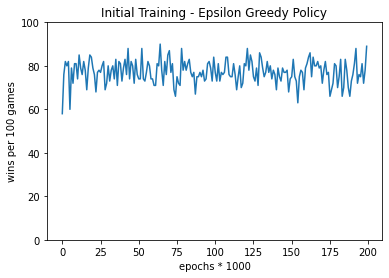

In [48]:
plt.plot(test0.win_count_list)
plt.title('Initial Training - Epsilon Greedy Policy')
plt.xlabel('epochs * 1000')
plt.ylabel('wins per 100 games')
plt.ylim(0, 100)
plt.show()

#Training while competing with a pre-trained agent
unlike the last training method, we would compete against the previous agent each 1000 epochs.

In [27]:
np.random.seed(42)
test00 = tic_tac_toe()
test00.train(100000,evaluation = True,opponent = test0,selected_policy = 'epsilon greedy')

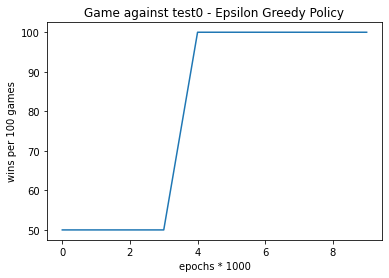

In [32]:
plt.plot(test00.win_count_list[:10])
plt.title('Game against test0 - Epsilon Greedy Policy')
plt.xlabel('epochs * 1000')
plt.ylabel('wins per 100 games')
plt.show()

#Training with an Initialized Q-Matrix
This time we would start the training with another agent's knowledge. we use test0 Q-Matrix for the initial values.

In [36]:
test00.save_Q()
test01 = tic_tac_toe()

In [37]:
test01.load_Q('Q-100000.csv')

In [38]:
test01.train(50000,evaluation = True,opponent = 'random',selected_policy = 'epsilon greedy')

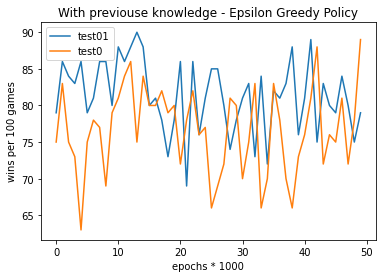

In [41]:
plt.plot(test01.win_count_list)
plt.plot(test0.win_count_list[-50:])
plt.title('With previouse knowledge - Epsilon Greedy Policy')
plt.xlabel('epochs * 1000')
plt.ylabel('wins per 100 games')
plt.legend(['test01','test0'])
plt.show()

The results seems better than the zeros initial Q-Matrix.

#Using other policies
Now we would try other policies to evaluate our agent's performance

In [4]:
np.random.seed(42)
test1 = tic_tac_toe()
test1.train(100000,evaluation = True,opponent = 'random',selected_policy = 'improved epsilon greedy')

In [6]:
np.random.seed(42)
test3 = tic_tac_toe()
test3.train(100000,evaluation = True,opponent = 'random',selected_policy = 'epsilon greedy')

In [7]:
np.random.seed(42)
test4 = tic_tac_toe()
test4.train(100000,evaluation = True,opponent = 'random',selected_policy = 'boltzmann')

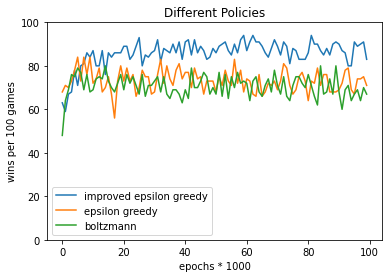

In [44]:
plt.plot(test1.win_count_list)
plt.plot(test3.win_count_list)
plt.plot(test4.win_count_list)
plt.ylim([0,100])
plt.legend(['improved epsilon greedy','epsilon greedy','boltzmann'])
plt.title('Different Policies')
plt.xlabel('epochs * 1000')
plt.ylabel('wins per 100 games')
plt.show()

as it can be seen, improved epsilon-greedy performed better than two other policies.

In [ ]:
np.random.seed(42)

epsilon_performance = {}

for e in [0.1,0.3,0.5,0.7,0.9]:
    test5 = tic_tac_toe(epsilon=e)
    test5.train(train_number=50000, evaluation = True, opponent = 'random', selected_policy = 'improved epsilon greedy',verbose = False)
    epsilon_performance[e] = test5.win_count_list
    

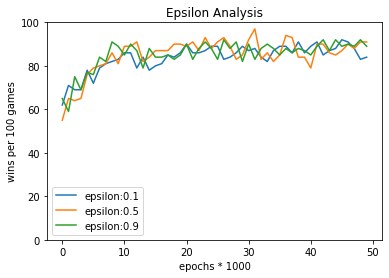

In [45]:
for performance in [0.1,0.5,0.9]:
    plt.plot(epsilon_performance[performance], label = f'epsilon:{performance}')
    plt.ylim([0,100])
plt.title('Epsilon Analysis')
plt.legend()
plt.xlabel('epochs * 1000')
plt.ylabel('wins per 100 games')
plt.show()

In [ ]:
np.random.seed(42)

gamma_performance = {}

for g in [0.1,0.3,0.5,0.7,0.9]:
    test6 = tic_tac_toe(gamma = g)
    test6.train(train_number=50000, evaluation = True, opponent = 'random', selected_policy = 'improved epsilon greedy',verbose = False)
    gamma_performance[g] = test6.win_count_list
    


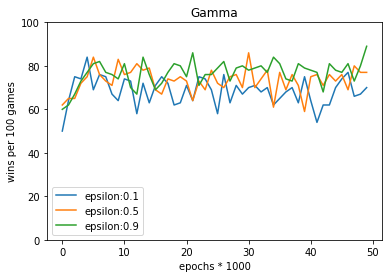

In [46]:
for performance in [0.1,0.5,0.9]:
    plt.plot(gamma_performance[performance], label = f'epsilon:{performance}')
    plt.ylim([0,100])
plt.title('Gamma')
plt.xlabel('epochs * 1000')
plt.ylabel('wins per 100 games')
plt.legend()
plt.show()

In [ ]:
np.random.seed(42)

alpha_performance = {}

for a in [0.1,0.3,0.5,0.7,0.9]:
    test7 = tic_tac_toe(alpha = a)
    test7.train(train_number=50000, evaluation = True, opponent = 'random', selected_policy = 'improved epsilon greedy',verbose = False)
    alpha_performance[a] = test7.win_count_list
    

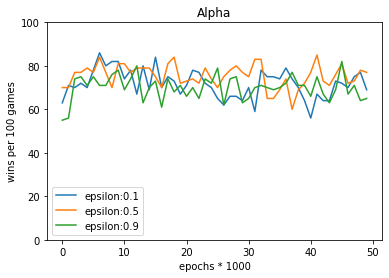

In [47]:
for performance in [0.1,0.5,0.9]:
    plt.plot(alpha_performance[performance], label = f'epsilon:{performance}')
    plt.ylim([0,100])
plt.title('Alpha')
plt.legend()
plt.xlabel('epochs * 1000')
plt.ylabel('wins per 100 games')
plt.show()

#Training with the best hyperparameters and the best policy

In [49]:
test8 = tic_tac_toe(epsilon=0.9, alpha=0.5, gamma=0.9)
test8.train(train_number=100000, evaluation = True, opponent = 'random', selected_policy = 'improved epsilon greedy')


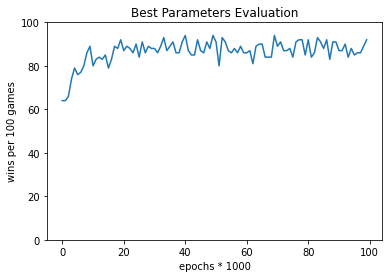

In [52]:
plt.plot(test8.win_count_list)
plt.title('Best Parameters Evaluation')
plt.xlabel('epochs * 1000')
plt.ylabel('wins per 100 games')
plt.ylim(0, 100)
plt.show()

As we can see it resulted in a better performance for the agent, and the agent reached better wining ratios after around 50K epochs with lower variance.

#Some othe feature of the Game environment:
####Saving a Q-Matrix
####Loading a pre-saved Q-Matrix
####Play Against the human in both interactive and GUI form

In [ ]:
#### You can create a game just by loading previous Q matrix

test9 = tit_tac_toe()
test9.load_Q('Q-150000.csv')

In [ ]:
# Saving the trained Q-Matrix for future usage
test10 = tic_tac_toe()
test10.train(train_number=500000, evaluation = True, opponent = 'random', selected_policy = 'improved epsilon greedy',verbose = False)
test10.save_Q()

In [ ]:
# Playing game with graphical interface

test10.play_gui()

In [ ]:
# Playing game in a code interactive way
test10.play_gui()